# Chapter 7: NLP LSTM
## Ex1: Identifying spam in popular YouTube videos comments with LSTM - Keras 
- Cho dữ liệu 'data/Youtube01-Psy.csv', 'data/Youtube02-KatyPerry.csv', 'data/Youtube03-LMFAO.csv',                'data/Youtube04-Eminem.csv', 'data/Youtube05-Shakira.csv'
- Xây dựng model dự đoán một nội dung là spam (1)/ham (0)
- Dự đoán các nội dung sau đây là spam (1)/ham (0):   data = ["Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!", "Why dafuq is a Korean song so big in the USA. Does that mean we support  Koreans? Last time I checked they wanted to bomb us."]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [ ]:
comments_df_list = []
comments_file = ['data/Youtube01-Psy.csv',
                 'data/Youtube02-KatyPerry.csv',
                 'data/Youtube03-LMFAO.csv',
                 'data/Youtube04-Eminem.csv',
                 'data/Youtube05-Shakira.csv']

                 
for f in comments_file:
    print(f)
    df = pd.read_csv(f,header=0)
    comments_df_list.append(df)
comments_df = pd.concat(comments_df_list)
# comments_df = comments_df.sample(frac=1.0)
print(comments_df.shape)
comments_df.head(5)

data/Youtube01-Psy.csv
data/Youtube02-KatyPerry.csv
data/Youtube03-LMFAO.csv
data/Youtube04-Eminem.csv
data/Youtube05-Shakira.csv
(1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [ ]:
comments_df.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')

In [ ]:
# https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
df = comments_df.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


In [ ]:
# df['V1'] = df['CLASS'].map(lambda x: 'ham' if x==0 else 'spam') 
df['WORDS'] = df['CONTENT'].map(lambda x: len(x.split()))
df.head()

,CONTENT,CLASS,WORDS
0,"Huh, anyway check out this you[tube] channel: ...",1,8
1,Hey guys check out my new channel and our firs...,1,30
2,just for test I have to say murdev.com,1,8
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,11
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,5


In [ ]:
df['WORDS'].describe()

count    1956.000000
mean       15.581800
std        21.532844
min         1.000000
25%         5.000000
50%         8.000000
75%        16.000000
max       213.000000
Name: WORDS, dtype: float64

In [ ]:
df.groupby("CLASS").mean("WORDS")

,WORDS
CLASS,
0,9.100946
1,21.714428


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Number of ham-0 and spam-1 content')

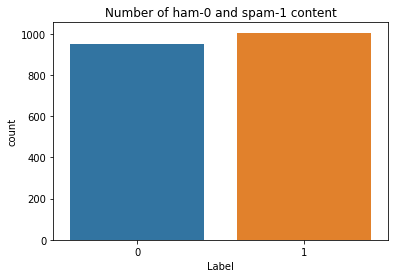

In [ ]:
sns.countplot(df.CLASS)
plt.xlabel('Label')
plt.title('Number of ham-0 and spam-1 content')

In [ ]:
X = df.CONTENT # input 
Y = df.CLASS # output

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

### Process the data
- Tokenize the data and convert the text to sequences.
- Add padding to ensure that all the sequences have the same shape.
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [ ]:
max_words = 1000
max_len = 100 # max = 213 => cho khoảng 1/2 của max là okk
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)


In [ ]:
print(sequences[:2])

[[347, 348, 14, 25, 3, 101, 14, 979, 4, 215, 246, 2], [539, 51, 980]]


In [ ]:
sequences_matrix[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 347, 348,  14,
         25,   3, 101,  14, 979,   4, 215, 246,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### RNN

In [ ]:
# RNN - LSTM nè
model = Sequential()
model.add(Embedding(max_words, 50))
model.add(LSTM(64))  # 32, 64, 128, ... hay gì gì cũng dc

# ANN
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# optimizer=RMSprop(): dùng cho bài toán có dạng tuần tự (text là tuần tự á)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),  
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


#### Tính tham số
- embedding layer = inputs x outputs = 1000 x 50 = 50000
- lstm layer =  [(num_units + input_dim + 1) x num_units] x 4  = (64 + 50 + 1)*64 *4 =  29440
- dense layer = 64*256 + 256 = 16640
- dropout = 0
- dense ouput layer = 256*1 + 1 = 257

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

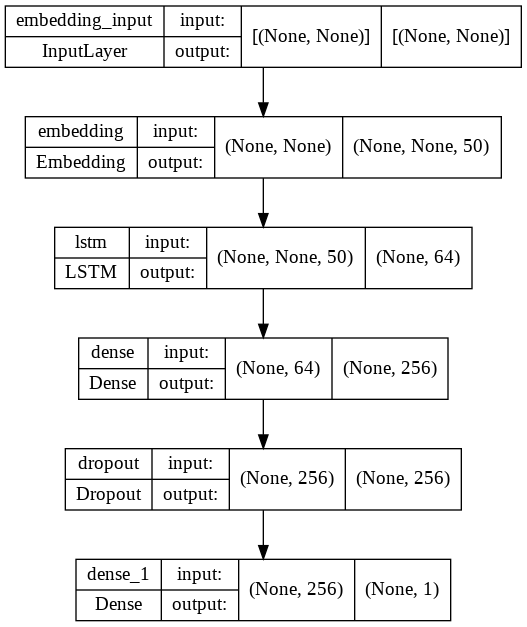

In [ ]:
# plot_model(model, to_file='LSTM_model.png', show_shapes=True)
# Image(filename='LSTM_model.png')

plot_model(model, show_shapes=True)

In [ ]:
# cross validation: tác dụng có thể xem dc model có ổn định hay ko
# vd: validation_split = 0.2 => kfoid = 1/0.2 = 5 => nó xác thực chéo 5 lần
history = model.fit(sequences_matrix, Y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2, # cross validation
                    callbacks=[EarlyStopping(monitor='val_acc', patience=5)])

Epoch 1/50
9/9 [==============================] - 4s 171ms/step - loss: 0.6663 - accuracy: 0.6621 - val_loss: 0.5728 - val_accuracy: 0.7810
Epoch 2/50
9/9 [==============================] - 1s 109ms/step - loss: 0.5642 - accuracy: 0.7653 - val_loss: 0.4208 - val_accuracy: 0.8431
Epoch 3/50
9/9 [==============================] - 1s 107ms/step - loss: 0.3511 - accuracy: 0.8776 - val_loss: 0.3123 - val_accuracy: 0.8905
Epoch 4/50
9/9 [==============================] - 1s 109ms/step - loss: 0.2141 - accuracy: 0.9306 - val_loss: 0.1962 - val_accuracy: 0.9161
Epoch 5/50
9/9 [==============================] - 1s 108ms/step - loss: 0.1295 - accuracy: 0.9571 - val_loss: 0.1825 - val_accuracy: 0.9270
Epoch 6/50
9/9 [==============================] - 1s 108ms/step - loss: 0.1975 - accuracy: 0.9224 - val_loss: 0.2006 - val_accuracy: 0.9088
Epoch 7/50
9/9 [==============================] - 1s 107ms/step - loss: 0.0982 - accuracy: 0.9671 - val_loss: 0.1847 - val_accuracy: 0.9161
Epoch 8/50
9/9 [====

In [ ]:
'''
sau khi xác thực chéo, train_acc = 0.9991, coss_test_acc = 0.94, => ổn.
check thử phần test có ok hay ko
'''

'\nsau khi xác thực chéo, train_acc = 0.9991, coss_test_acc = 0.94, => ổn.\ncheck thử phần test có ok hay ko\n'

In [ ]:
# test: text to sequence
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

19/19 [==============================] - 0s 14ms/step - loss: 0.7443 - accuracy: 0.9421


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.744
  Accuracy: 0.942


In [ ]:
'''
nói chung model okk
'''

In [ ]:
#Save the result
from tensorflow.keras.models import load_model
# Creates a HDF5 file 'my_model.h5'
model.save('LSTM_spam_model.h5')

### Make new predictions

In [ ]:
type(X_test)

pandas.core.series.Series

In [ ]:
X_new = pd.Series(data = ["Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!", 
         "Why dafuq is a Korean song so big in the USA. Does that mean we support  Koreans? Last time I checked they wanted to bomb us."])
test_sequences_new = tok.texts_to_sequences(X_new)
test_sequences_matrix_new = sequence.pad_sequences(test_sequences_new,maxlen=max_len)

In [ ]:
X_new

0    Hey guys check out my new channel and our firs...
1    Why dafuq is a Korean song so big in the USA. ...
dtype: object

In [ ]:
test_sequences_matrix_new

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  63,  45,  10,   9,   8,  40,  30,   6,
         89, 162, 631,   3,  14, 148,   4, 152,   4, 990,  25,   4, 548,
        991,  22, 296,   5,  21,  68,   6,  22,  29],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
# prediction
model.predict(test_sequences_matrix_new)

array([[1.0000000e+00],
       [1.6394258e-04]], dtype=float32)

In [ ]:
'''
1: spam
0: no spam

'''